# Анализ частотной составляющей аудио

Типа как Tonal Balance Control из iZotope

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydub
from scipy import signal

%matplotlib inline

Тут может быть путь к вашему звуковому файлу:

In [2]:
song_path = '../data/norway2_6_slice.wav'
song = pydub.AudioSegment.from_wav(song_path)

Частотные полосы, по которым ориентируется iZotope Tonal Balance Control (цифры взяты из документации):
- низкие 0 – 250 Hz
- средне-низкие 250 – 2000 Hz
- средне-высокие 2000 – 8000 Hz
- высокие 8000 – 20000 Hz

Судя по всему, белые горизонтальные полоски в Broad View показывают, в какой пропорции находятся суммы амплитуд в каждой из частотных полос. И нужно, чтобы они были примерно в такой же пропорции, как у референсного трека или жанра. Пропорции для референсного трека или жанра показывают широкими синими полосками.

А в Fine View просто показывают график частота-амплитуда, и нужно стремиться, чтобы он примерно совпадал с референсным. Референсный график показан синей полосой.

In [3]:
low_border = 20
low_mid_border = 250
mid_low_mid_hi_border = 2000
mid_hi_border = 8000
hi_border = 20000

In [4]:
song_slice = song
song_slice

In [5]:
print('''
Channels count: {}
Length: {} sec
Bits per sample: {}
Framerate: {} Hz
RMS: {}
Peak amplitude: {}
Peak amplitude in dBFS: {}
Frames in one ms: {}
Frames count: {}'''.format(
    song_slice.channels,
    song_slice.duration_seconds,
    song_slice.sample_width * 8,
    song_slice.frame_rate,
    song_slice.rms,
    song_slice.max,
    song_slice.max_dBFS,
    song_slice.frame_count(ms=1),
    song_slice.frame_count()
))


Channels count: 2
Length: 21.943 sec
Bits per sample: 16
Framerate: 48000 Hz
RMS: 2988
Peak amplitude: 27311
Peak amplitude in dBFS: -1.5822466542679465
Frames in one ms: 48.0
Frames count: 1053264.0


In [6]:
def get_samples(song):
    samples = song.get_array_of_samples()
    samples = np.array(samples).reshape(-1, 2)
    return samples[:,0], samples[:, 1]

def get_bands(
    signal,
    freq,
    low_border=20,
    low_mid_border=250,
    mid_low_mid_hi_border=2000,
    mid_hi_border=8000,
    hi_border=20000
):
    low_index = (freq > low_border) & (freq <= low_mid_border)
    low = signal[low_index]
    mid_low_index = (freq > low_mid_border) & (freq <= mid_low_mid_hi_border)
    mid_low = signal[mid_low_index]
    mid_hi_index = (freq > mid_low_mid_hi_border) & (freq <= mid_hi_border)
    mid_hi = signal[mid_hi_index]
    hi_index = (freq > mid_hi_border) & (freq <= hi_border)
    hi = signal[hi_index]
    return low, mid_low, mid_hi, hi, low_index, mid_low_index, mid_hi_index, hi_index

def amplitude_to_db(amplitude):
    return 20 * np.log10(amplitude / np.max(amplitude))

In [7]:
left, right = get_samples(song_slice)

# Спектрограмма

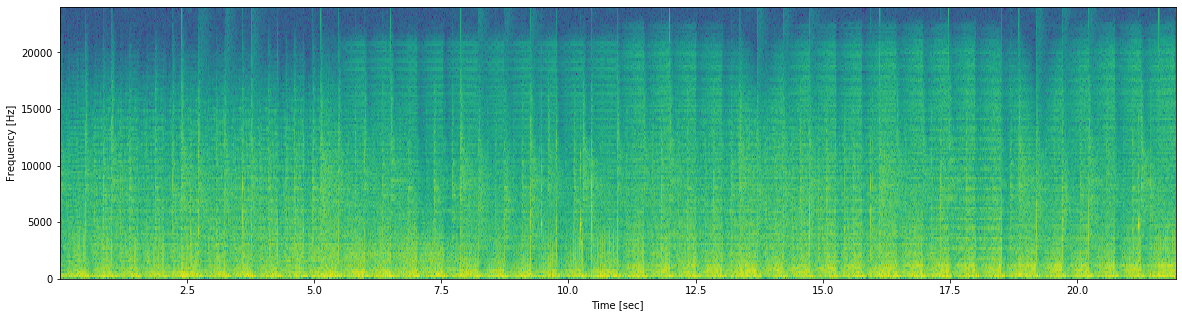

In [36]:
f, t, Sxx = signal.spectrogram(left, song_slice.frame_rate)
plt.figure(figsize=(20,5))
plt.pcolormesh(t, f, amplitude_to_db(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# Частотная кривая в момент времени 0:

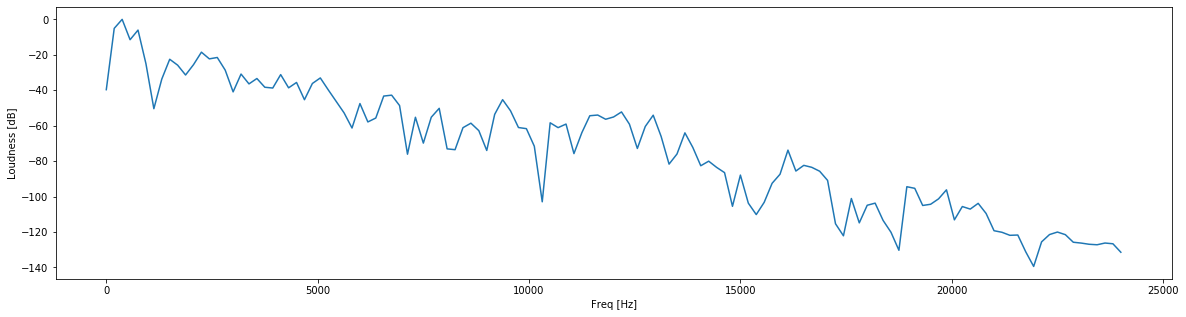

In [35]:
plt.figure(figsize=(20,5))
plt.plot(f, amplitude_to_db(Sxx[:,0]))
plt.ylabel('Loudness [dB]')
plt.xlabel('Freq [Hz]')
plt.show()

In [10]:
Sxx.shape

(129, 4701)

# Частотная кривая усреднённая по всему фрагменту:

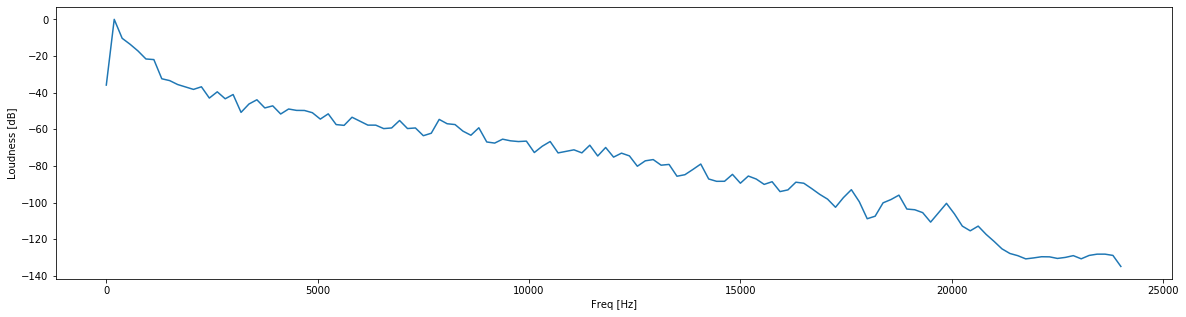

In [34]:
plt.figure(figsize=(20,5))
plt.plot(f, amplitude_to_db(np.mean(Sxx, axis=1)))
plt.ylabel('Loudness [dB]')
plt.xlabel('Freq [Hz]')
plt.show()

# Средняя громкость по полосам:

In [27]:
low, mid_low, mid_hi, hi, \
low_index, mid_low_index, mid_hi_index, hi_index = get_bands(amplitude_to_db(np.mean(Sxx, axis=1)), f)

In [31]:
means_by_band = [np.mean(low), np.mean(mid_low), np.mean(mid_hi), np.mean(hi)]
bands_start = [low_border, low_mid_border, mid_low_mid_hi_border, mid_hi_border]
bands_end = [low_mid_border-1, mid_low_mid_hi_border-1, mid_hi_border-1, hi_border]
horizontal[low_index] = np.mean(low)
horizontal[mid_low_index] = np.mean(mid_low)
horizontal[mid_hi_index] = np.mean(mid_hi)
horizontal[hi_index] = np.mean(hi)

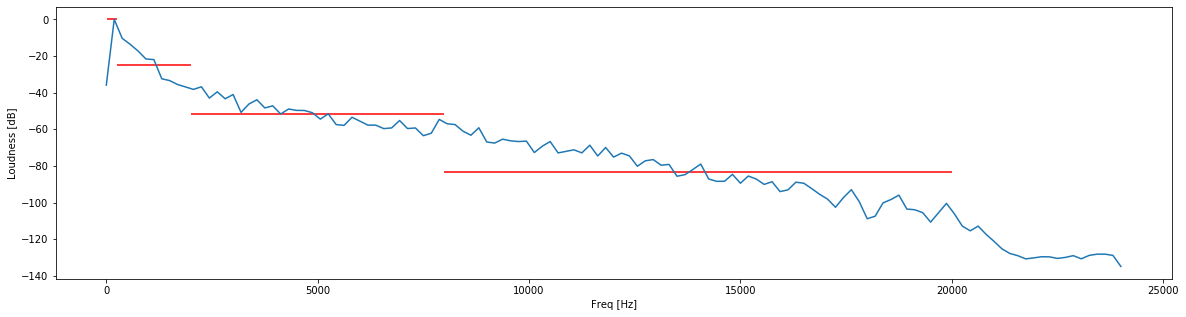

In [42]:
plt.figure(figsize=(20,5))
plt.plot(f, amplitude_to_db(np.mean(Sxx, axis=1)))
plt.hlines(means_by_band, bands_start, bands_end, colors='red')
plt.ylabel('Loudness [dB]')
plt.xlabel('Freq [Hz]')
plt.show()